In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, Input, Bidirectional, LSTM, TimeDistributed, RNN, BatchNormalization
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import shutil
import cv2
import os

print ('Library loaded')

Library loaded


In [2]:
os.mkdir('/kaggle/working/file_training')

In [3]:
inp = '/kaggle/input/lung-disease-5-class'
os.listdir(inp)

['viral_pneumonia', 'tuberculosis', 'normal', 'covid19', 'bacterial_pneumonia']

In [4]:
input_dir = '/kaggle/input/lung-disease-5-class'
output_dir = '/kaggle/working/lung disease'

shutil.copytree(input_dir, output_dir)

print("Isi dari direktori output:")
print(os.listdir(output_dir))

Isi dari direktori output:
['bacterial_pneumonia', 'covid19', 'normal', 'viral_pneumonia', 'tuberculosis']


In [5]:
classes = ['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']
inp2 = '/kaggle/working/lung disease'

lungdisease_dir = os.path.join(inp2, 'lungdisease')
os.makedirs(lungdisease_dir, exist_ok=True)

train_dir = os.path.join(lungdisease_dir, 'train_dir')
os.makedirs(train_dir, exist_ok=True)

test_dir = os.path.join(lungdisease_dir, 'test_dir')
os.makedirs(test_dir, exist_ok=True)

for class_name in classes:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

for class_name in classes:
    class_dir = os.path.join(inp2, class_name)
    files = os.listdir(class_dir)
    train_files, test_files = train_test_split(files, test_size=0.2, random_state=42)
    
    for file in train_files:
        src = os.path.join(class_dir, file)
        dest = os.path.join(train_dir, class_name, file)
        shutil.copy(src, dest)
        
    for file in test_files:
        src = os.path.join(class_dir, file)
        dest = os.path.join(test_dir, class_name, file)
        shutil.copy(src, dest)

print("Berhasil.")


Berhasil.


In [6]:
train_dir = os.path.join(inp2, 'lungdisease', 'train_dir')
test_dir = os.path.join(inp2, 'lungdisease', 'test_dir')

print("Jumlah gambar untuk setiap kelas di train_dir:")
for class_name in classes:
    class_path = os.path.join(train_dir, class_name)
    num_files = len(os.listdir(class_path))
    print(f"{class_name}: {num_files} gambar")

print("\nJumlah gambar untuk setiap kelas di test_dir:")
for class_name in classes:
    class_path = os.path.join(test_dir, class_name)
    num_files = len(os.listdir(class_path))
    print(f"{class_name}: {num_files} gambar")

Jumlah gambar untuk setiap kelas di train_dir:
bacterial_pneumonia: 820 gambar
covid19: 843 gambar
normal: 835 gambar
tuberculosis: 560 gambar
viral_pneumonia: 862 gambar

Jumlah gambar untuk setiap kelas di test_dir:
bacterial_pneumonia: 206 gambar
covid19: 211 gambar
normal: 209 gambar
tuberculosis: 140 gambar
viral_pneumonia: 216 gambar


In [7]:
train_dir = os.path.join(inp2, 'lungdisease', 'train_dir')
test_dir = os.path.join(inp2, 'lungdisease', 'test_dir')

total_train_data = sum([len(files) for _, _, files in os.walk(train_dir)])

total_test_data = sum([len(files) for _, _, files in os.walk(test_dir)])

print(f"Total data pada train_dir: {total_train_data}")
print(f"Total data pada test_dir: {total_test_data}")

Total data pada train_dir: 3920
Total data pada test_dir: 982


In [8]:
#augmentasi gambar
base = '/kaggle/working/lung disease/lungdisease'
class_name = ["bacterial_pneumonia", "covid19", "normal", "tuberculosis", "viral_pneumonia"]
for img_class in class_name:
    aug_dir = os.path.join(base, "aug_dir")
    os.mkdir(aug_dir)
    img_dir = os.path.join(aug_dir, "img_dir")
    os.mkdir(img_dir)

    img_list = os.listdir(
        os.path.join(base, "train_dir", img_class)
    )
    for file_name in img_list:
        source = os.path.join(
            base, "train_dir", img_class, file_name
        )
        target = os.path.join(img_dir, file_name)
        shutil.copyfile(source, target)

    source_path = aug_dir
    save_path = os.path.join(base, "train_dir", img_class)
    batch_size = 50

    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=90,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.05,
    )

    aug_datagen = datagen.flow_from_directory(
        source_path,
        save_to_dir=save_path,
        save_format="jpg",
        target_size=(224, 224),
        batch_size=batch_size,
    )
    aug_images = 1200

    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((aug_images - num_files) / batch_size))

    for i in range(0, num_batches):
        images, labels = next(aug_datagen)

    # hapus temporary directory
    shutil.rmtree(aug_dir)

Found 820 images belonging to 1 classes.
Found 843 images belonging to 1 classes.
Found 835 images belonging to 1 classes.
Found 560 images belonging to 1 classes.
Found 862 images belonging to 1 classes.


In [9]:
#menghitung total kelas setelah augmentasi pada train set
def count_images_per_class(directory):
    class_counts = {}

    for img_class in os.listdir(directory):
        class_path = os.path.join(directory, img_class)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            class_counts[img_class] = num_images

    return class_counts


augmented_train_dir = os.path.join(base, "train_dir")

augmented_class_counts = count_images_per_class(augmented_train_dir)

print("Banyak gambar per kelas pada train_df setelah augmentasi:")
for img_class, count in augmented_class_counts.items():
    print(f"{img_class}: {count} images")

Banyak gambar per kelas pada train_df setelah augmentasi:
bacterial_pneumonia: 1220 images
covid19: 1243 images
normal: 1235 images
viral_pneumonia: 1212 images
tuberculosis: 1170 images


In [10]:
train_path = '/kaggle/working/lung disease/lungdisease/train_dir'
test_path = '/kaggle/working/lung disease/lungdisease/test_dir'

batch_size = 32

image_size = 224

## ResNet50

In [11]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,shuffle=True)

test_batches = datagen.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,shuffle=False)

Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


In [12]:
base_model_resnet50 = tf.keras.applications.ResNet50(
    include_top=False, weights="imagenet", input_shape=(image_size, image_size, 3)
)

for layer in base_model_resnet50.layers:
    layer.trainable = False

94781440/94765736 [==============================] - 1s 0us/step


In [13]:
model_resnet50 = Sequential()
model_resnet50.add(base_model_resnet50)
model_resnet50.add(TimeDistributed(Flatten()))
model_resnet50.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model_resnet50.add(Dropout(0.25))
model_resnet50.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model_resnet50.add(Dropout(0.25))
model_resnet50.add(Dense(50, activation="relu"))
model_resnet50.add(Dropout(0.5))
model_resnet50.add(Dense(5, activation="softmax"))

model_resnet50.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
time_distributed (TimeDistri (None, 7, 14336)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 7, 256)            14812160  
_________________________________________________________________
dropout (Dropout)            (None, 7, 256)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                1

In [14]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model_resnet50.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

checkpoint = ModelCheckpoint(
    filepath="/kaggle/working/file_training/resnet50.h5",
    monitor="val_acc",
    save_best_only=True,
    verbose=1,
    mode="max",
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_acc",
    factor=0.5,
    patience=2,
    verbose=1,
    mode="max",
    min_lr=1e-6,
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=7,
    restore_best_weights=True,
)

In [15]:
history_resnet50 = model_resnet50.fit(train_batches, validation_data=test_batches, epochs=25, verbose=1, callbacks=[early_stopping, reduce_lr])

Epoch 1/25
190/190 [==============================] - 50s 169ms/step - loss: 0.6921 - acc: 0.7048 - val_loss: 0.3765 - val_acc: 0.8483
Epoch 2/25
190/190 [==============================] - 29s 153ms/step - loss: 0.4081 - acc: 0.8498 - val_loss: 0.2140 - val_acc: 0.9308
Epoch 3/25
190/190 [==============================] - 29s 155ms/step - loss: 0.3063 - acc: 0.8926 - val_loss: 0.2542 - val_acc: 0.9002
Epoch 4/25
190/190 [==============================] - 30s 155ms/step - loss: 0.2669 - acc: 0.9095 - val_loss: 0.2032 - val_acc: 0.9246

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/25
190/190 [==============================] - 29s 155ms/step - loss: 0.1752 - acc: 0.9406 - val_loss: 0.1256 - val_acc: 0.9582
Epoch 6/25
190/190 [==============================] - 29s 154ms/step - loss: 0.1361 - acc: 0.9554 - val_loss: 0.1421 - val_acc: 0.9552
Epoch 7/25
190/190 [==============================] - 30s 157ms/step - loss: 0.1087 - acc: 0.9646 - val_loss:

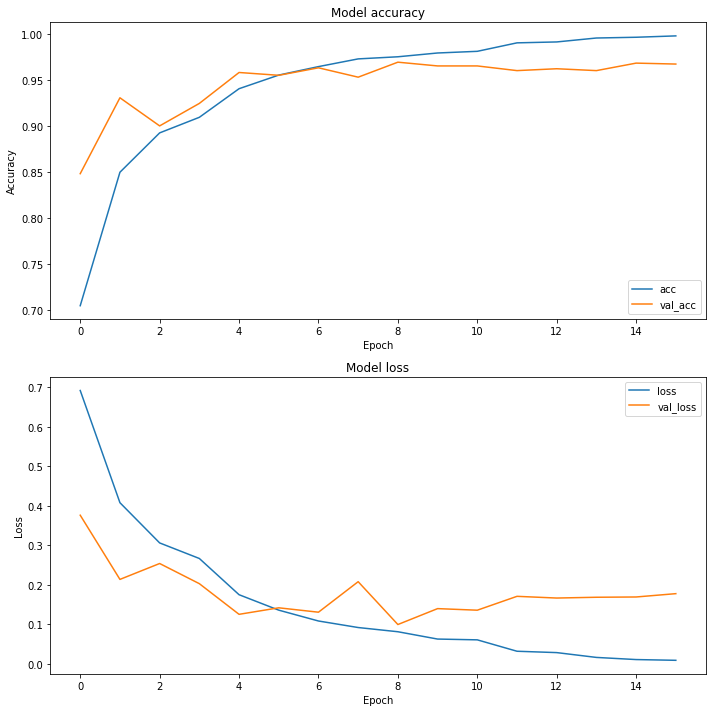

In [16]:
plt.figure(figsize=(10,10))
# Plot grafik akurasi
plt.subplot(2, 1, 1)
plt.plot(history_resnet50.history["acc"])
plt.plot(history_resnet50.history["val_acc"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["acc", "val_acc"], loc="lower right")

# Plot grafik loss
plt.subplot(2, 1, 2)
plt.plot(history_resnet50.history["loss"])
plt.plot(history_resnet50.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss", "val_loss"], loc="upper right")

plt.tight_layout()  # Agar grafik tidak tumpang tindih
plt.show()


In [17]:
train_score = model_resnet50.evaluate(train_batches, verbose=1)
test_score = model_resnet50.evaluate(test_batches, verbose=1)

31/31 [==============================] - 5s 157ms/step - loss: 0.0998 - acc: 0.9695


In [18]:
model_resnet50.save("/kaggle/working/file_training/resnet50.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [19]:
y_true = np.array([])
for i in range(len(test_batches)):
    batch = next(test_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(test_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 982 images belonging to 5 classes.
31/31 [==============================] - 7s 152ms/step

Classification Report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.98020   0.96117   0.97059       206
            covid19    0.96262   0.97630   0.96941       211
             normal    0.97512   0.93780   0.95610       209
       tuberculosis    0.99291   1.00000   0.99644       140
    viral_pneumonia    0.94643   0.98148   0.96364       216

           accuracy                        0.96945       982
          macro avg    0.97146   0.97135   0.97124       982
       weighted avg    0.96972   0.96945   0.96941       982



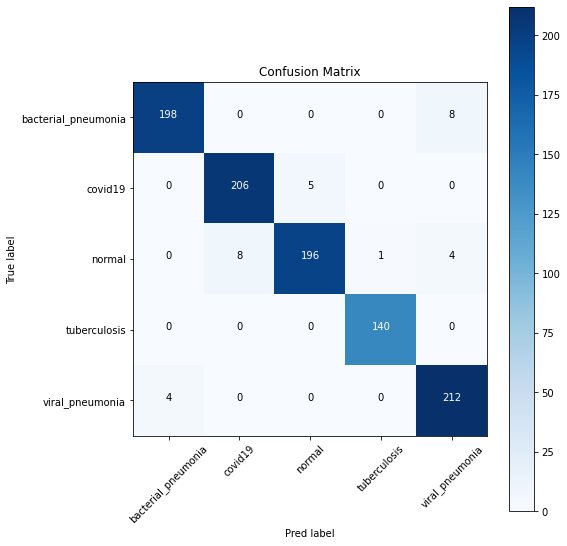

In [20]:
test_all_batches = datagen.flow_from_directory(
    directory=test_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)
true_labels = test_batches.classes

num_test_steps = len(test_all_batches)

predictions = model_resnet50.predict(test_batches, steps=num_test_steps, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)
class_report = classification_report(
    true_labels, predicted_labels, target_names=train_batches.class_indices, digits=5
)
print("\nClassification Report:\n", class_report)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)
thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(
        j,
        i,
        conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

In [21]:
y_true = np.array([])
for i in range(len(train_batches)):
    batch = next(train_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(train_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 6080 images belonging to 5 classes.
190/190 [==============================] - 26s 135ms/step

Training Classification Report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.99507   0.99344   0.99426      1220
            covid19    0.99758   0.99678   0.99718      1243
             normal    0.99757   0.99757   0.99757      1235
       tuberculosis    0.99915   1.00000   0.99957      1170
    viral_pneumonia    0.99341   0.99505   0.99423      1212

           accuracy                        0.99655      6080
          macro avg    0.99656   0.99657   0.99656      6080
       weighted avg    0.99655   0.99655   0.99655      6080



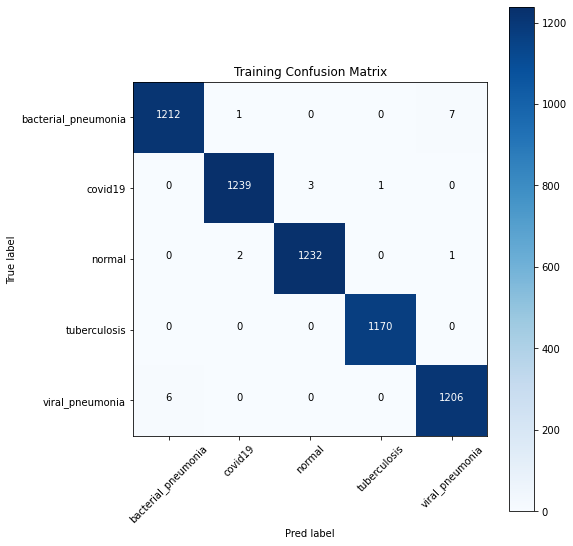

In [22]:
train_all_batches = datagen.flow_from_directory(
    directory=train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)

num_train_steps = len(train_all_batches)

train_predictions = model_resnet50.predict(train_all_batches, steps=num_train_steps, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_all_batches.classes

train_class_report = classification_report(
    train_true_labels,
    train_predicted_labels,
    target_names=train_all_batches.class_indices,
    digits=5,
)
print("\nTraining Classification Report:\n", train_class_report)

train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## VGG19

In [23]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,shuffle=True)

test_batches = datagen.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,shuffle=False)

Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


In [24]:
base_model_vgg19 = tf.keras.applications.VGG19(
    include_top=False, weights="imagenet", input_shape=(image_size, image_size, 3)
)

for layer in base_model_vgg19.layers:
    layer.trainable = False

80150528/80134624 [==============================] - 0s 0us/step


In [25]:
model_vgg19 = Sequential()
model_vgg19.add(base_model_vgg19)
model_vgg19.add(TimeDistributed(Flatten()))
model_vgg19.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model_vgg19.add(Dropout(0.25))
model_vgg19.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model_vgg19.add(Dropout(0.25))
model_vgg19.add(Dense(50, activation="relu"))
model_vgg19.add(Dropout(0.5))
model_vgg19.add(Dense(5, activation="softmax"))

model_vgg19.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 7, 3584)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 7, 256)            3802112   
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 256)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)               

In [26]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model_vgg19.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

checkpoint = ModelCheckpoint(
    filepath="/kaggle/working/file_training/vgg19.h5",
    monitor="val_acc",
    save_best_only=True,
    verbose=1,
    mode="max",
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_acc",
    factor=0.5,
    patience=2,
    verbose=1,
    mode="max",
    min_lr=1e-6,
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=7,
    restore_best_weights=True,
)

In [27]:
history_vgg19 = model_vgg19.fit(train_batches, validation_data=test_batches, epochs=25, verbose=1, callbacks=[early_stopping, reduce_lr])

Epoch 1/25
190/190 [==============================] - 54s 221ms/step - loss: 0.7262 - acc: 0.6997 - val_loss: 0.4174 - val_acc: 0.8310
Epoch 2/25
190/190 [==============================] - 36s 188ms/step - loss: 0.4536 - acc: 0.8270 - val_loss: 0.3157 - val_acc: 0.8717
Epoch 3/25
190/190 [==============================] - 36s 189ms/step - loss: 0.3862 - acc: 0.8572 - val_loss: 0.3172 - val_acc: 0.8656
Epoch 4/25
190/190 [==============================] - 36s 189ms/step - loss: 0.3521 - acc: 0.8720 - val_loss: 0.2769 - val_acc: 0.8900
Epoch 5/25
190/190 [==============================] - 36s 190ms/step - loss: 0.2939 - acc: 0.8967 - val_loss: 0.2375 - val_acc: 0.8941
Epoch 6/25
190/190 [==============================] - 36s 189ms/step - loss: 0.2866 - acc: 0.9005 - val_loss: 0.2499 - val_acc: 0.9033
Epoch 7/25
190/190 [==============================] - 36s 189ms/step - loss: 0.2501 - acc: 0.9127 - val_loss: 0.2121 - val_acc: 0.9236
Epoch 8/25
190/190 [==============================] - 3

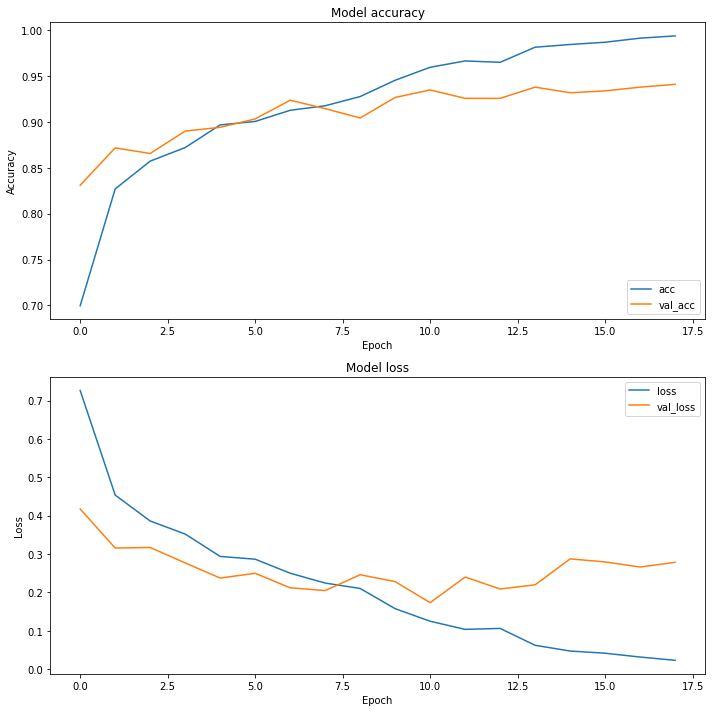

In [28]:
plt.figure(figsize=(10,10))
# Plot grafik akurasi
plt.subplot(2, 1, 1)
plt.plot(history_vgg19.history["acc"])
plt.plot(history_vgg19.history["val_acc"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["acc", "val_acc"], loc="lower right")

# Plot grafik loss
plt.subplot(2, 1, 2)
plt.plot(history_vgg19.history["loss"])
plt.plot(history_vgg19.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss", "val_loss"], loc="upper right")

plt.tight_layout()  # Agar grafik tidak tumpang tindih
plt.show()


In [29]:
train_score = model_vgg19.evaluate(train_batches, verbose=1)
test_score = model_vgg19.evaluate(test_batches, verbose=1)

31/31 [==============================] - 6s 180ms/step - loss: 0.1733 - acc: 0.9348


In [30]:
model_vgg19.save("/kaggle/working/file_training/vgg19.h5")

In [31]:
y_true = np.array([])
for i in range(len(test_batches)):
    batch = next(test_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(test_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 982 images belonging to 5 classes.
31/31 [==============================] - 7s 170ms/step

Classification Report VGG19:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.89423   0.90291   0.89855       206
            covid19    0.95714   0.95261   0.95487       211
             normal    0.95652   0.94737   0.95192       209
       tuberculosis    0.98561   0.97857   0.98208       140
    viral_pneumonia    0.89908   0.90741   0.90323       216

           accuracy                        0.93483       982
          macro avg    0.93852   0.93777   0.93813       982
       weighted avg    0.93510   0.93483   0.93495       982



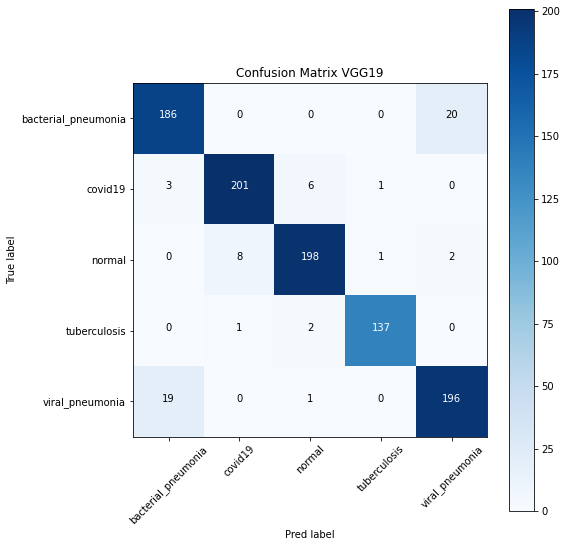

In [32]:
test_all_batches = datagen.flow_from_directory(
    directory=test_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)
true_labels = test_batches.classes

num_test_steps = len(test_all_batches)

predictions = model_vgg19.predict(test_batches, steps=num_test_steps, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)
class_report = classification_report(
    true_labels, predicted_labels, target_names=train_batches.class_indices, digits=5
)
print("\nClassification Report VGG19:\n", class_report)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix VGG19")
plt.colorbar()
tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)
thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(
        j,
        i,
        conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

In [33]:
y_true = np.array([])
for i in range(len(train_batches)):
    batch = next(train_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(train_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 6080 images belonging to 5 classes.
190/190 [==============================] - 32s 168ms/step

Training Classification Report VGG19:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.97362   0.96803   0.97082      1220
            covid19    0.99195   0.99195   0.99195      1243
             normal    0.98872   0.99352   0.99111      1235
       tuberculosis    0.99828   0.99316   0.99572      1170
    viral_pneumonia    0.96555   0.97112   0.96833      1212

           accuracy                        0.98355      6080
          macro avg    0.98362   0.98356   0.98359      6080
       weighted avg    0.98357   0.98355   0.98356      6080



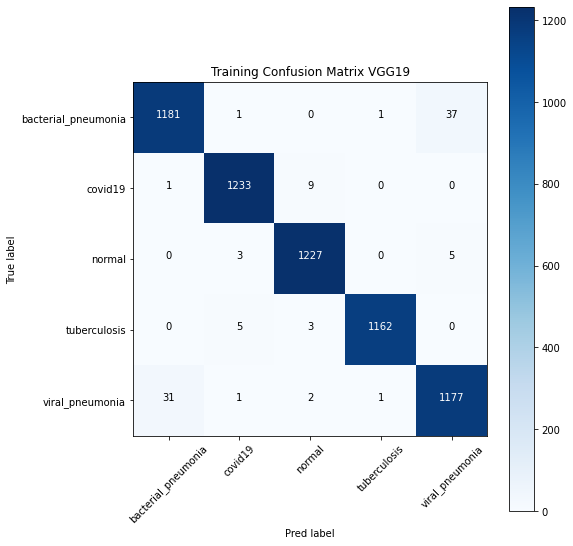

In [34]:
train_all_batches = datagen.flow_from_directory(
    directory=train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)

num_train_steps = len(train_all_batches)

train_predictions = model_vgg19.predict(train_all_batches, steps=num_train_steps, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_all_batches.classes

train_class_report = classification_report(
    train_true_labels,
    train_predicted_labels,
    target_names=train_all_batches.class_indices,
    digits=5,
)
print("\nTraining Classification Report VGG19:\n", train_class_report)

train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix VGG19")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## InceptionV3

In [35]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,shuffle=True)

test_batches = datagen.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,shuffle=False)

Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


In [36]:
base_model_inceptionv3 = tf.keras.applications.InceptionV3(
    include_top=False, weights="imagenet", input_shape=(image_size, image_size, 3)
)

for layer in base_model_inceptionv3.layers:
    layer.trainable = False

87924736/87910968 [==============================] - 0s 0us/step


In [37]:
model_inceptionv3 = Sequential()
model_inceptionv3.add(base_model_inceptionv3)
model_inceptionv3.add(TimeDistributed(Flatten()))
model_inceptionv3.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model_inceptionv3.add(Dropout(0.25))
model_inceptionv3.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model_inceptionv3.add(Dropout(0.25))
model_inceptionv3.add(Dense(50, activation="relu"))
model_inceptionv3.add(Dropout(0.5))
model_inceptionv3.add(Dense(5, activation="softmax"))

model_inceptionv3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
time_distributed_2 (TimeDist (None, 5, 10240)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 5, 256)            10617856  
_________________________________________________________________
dropout_6 (Dropout)          (None, 5, 256)            0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)               

In [38]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model_inceptionv3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

checkpoint = ModelCheckpoint(
    filepath="/kaggle/working/file_training/inceptionv3.h5",
    monitor="val_acc",
    save_best_only=True,
    verbose=1,
    mode="max",
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_acc",
    factor=0.5,
    patience=2,
    verbose=1,
    mode="max",
    min_lr=1e-6,
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=7,
    restore_best_weights=True,
)

In [39]:
history_inceptionv3 = model_inceptionv3.fit(train_batches, validation_data=test_batches, epochs=25, verbose=1, callbacks=[early_stopping, reduce_lr])

Epoch 1/25
190/190 [==============================] - 39s 154ms/step - loss: 1.0018 - acc: 0.5327 - val_loss: 0.6626 - val_acc: 0.7210
Epoch 2/25
190/190 [==============================] - 25s 133ms/step - loss: 0.7735 - acc: 0.6434 - val_loss: 0.6008 - val_acc: 0.6976
Epoch 3/25
190/190 [==============================] - 26s 136ms/step - loss: 0.6802 - acc: 0.6849 - val_loss: 0.5981 - val_acc: 0.6894

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/25
190/190 [==============================] - 26s 134ms/step - loss: 0.5953 - acc: 0.7253 - val_loss: 0.5255 - val_acc: 0.7821
Epoch 5/25
190/190 [==============================] - 25s 133ms/step - loss: 0.5445 - acc: 0.7612 - val_loss: 0.5511 - val_acc: 0.7057
Epoch 6/25
190/190 [==============================] - 25s 133ms/step - loss: 0.5070 - acc: 0.7776 - val_loss: 0.4725 - val_acc: 0.7933
Epoch 7/25
190/190 [==============================] - 26s 134ms/step - loss: 0.4484 - acc: 0.8081 - val_loss:

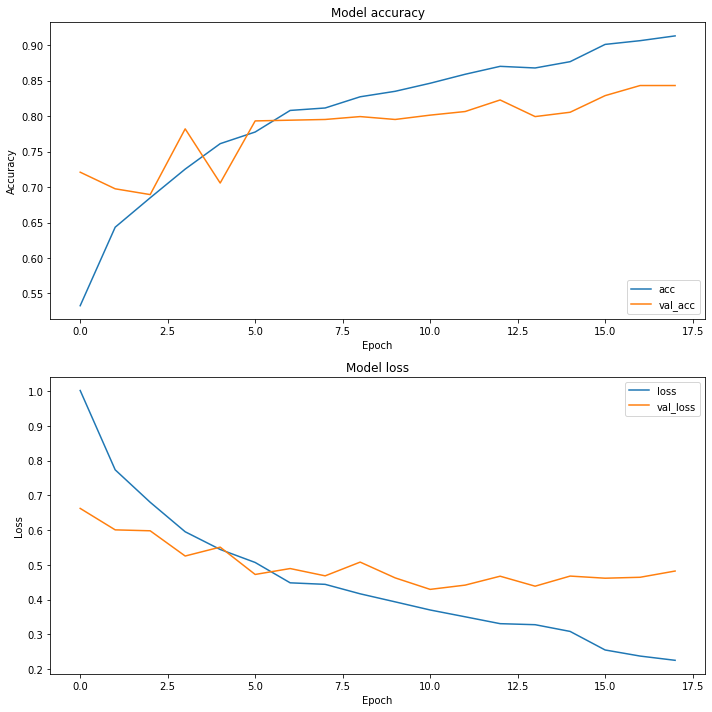

In [40]:
plt.figure(figsize=(10,10))
# Plot grafik akurasi
plt.subplot(2, 1, 1)
plt.plot(history_inceptionv3.history["acc"])
plt.plot(history_inceptionv3.history["val_acc"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["acc", "val_acc"], loc="lower right")

# Plot grafik loss
plt.subplot(2, 1, 2)
plt.plot(history_inceptionv3.history["loss"])
plt.plot(history_inceptionv3.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss", "val_loss"], loc="upper right")

plt.tight_layout()  # Agar grafik tidak tumpang tindih
plt.show()


In [41]:
train_score = model_inceptionv3.evaluate(train_batches, verbose=1)
test_score = model_inceptionv3.evaluate(test_batches, verbose=1)

31/31 [==============================] - 4s 141ms/step - loss: 0.4296 - acc: 0.8014


In [42]:
model_inceptionv3.save("/kaggle/working/file_training/inceptionv3.h5")

In [43]:
y_true = np.array([])
for i in range(len(test_batches)):
    batch = next(test_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(test_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 982 images belonging to 5 classes.
31/31 [==============================] - 7s 140ms/step

Classification Report InceptionV3 :
                      precision    recall  f1-score   support

bacterial_pneumonia    0.61620   0.84951   0.71429       206
            covid19    0.86364   0.90047   0.88167       211
             normal    0.89524   0.89952   0.89737       209
       tuberculosis    0.98413   0.88571   0.93233       140
    viral_pneumonia    0.77465   0.50926   0.61453       216

           accuracy                        0.80143       982
          macro avg    0.82677   0.80890   0.80804       982
       weighted avg    0.81606   0.80143   0.79836       982



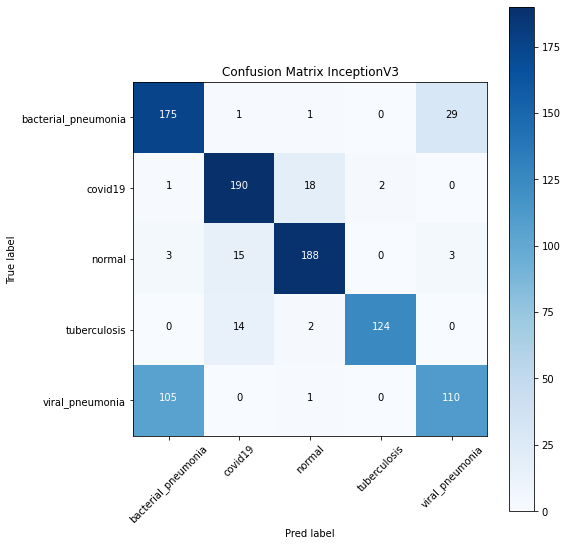

In [44]:
test_all_batches = datagen.flow_from_directory(
    directory=test_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)
true_labels = test_batches.classes
# model.load_weights("VGG16fix.hdf5")

num_test_steps = len(test_all_batches)

predictions = model_inceptionv3.predict(test_batches, steps=num_test_steps, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)
class_report = classification_report(
    true_labels, predicted_labels, target_names=train_batches.class_indices, digits=5
)
print("\nClassification Report InceptionV3 :\n", class_report)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix InceptionV3")
plt.colorbar()
tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)
thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(
        j,
        i,
        conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

In [45]:
y_true = np.array([])
for i in range(len(train_batches)):
    batch = next(train_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(train_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 6080 images belonging to 5 classes.
190/190 [==============================] - 22s 115ms/step

Training Classification Report InceptionV3 :
                      precision    recall  f1-score   support

bacterial_pneumonia    0.70038   0.90820   0.79086      1220
            covid19    0.95867   0.95173   0.95519      1243
             normal    0.93638   0.97733   0.95642      1235
       tuberculosis    1.00000   0.96838   0.98393      1170
    viral_pneumonia    0.86580   0.60149   0.70983      1212

           accuracy                        0.88158      6080
          macro avg    0.89225   0.88142   0.87925      6080
       weighted avg    0.89175   0.88158   0.87909      6080



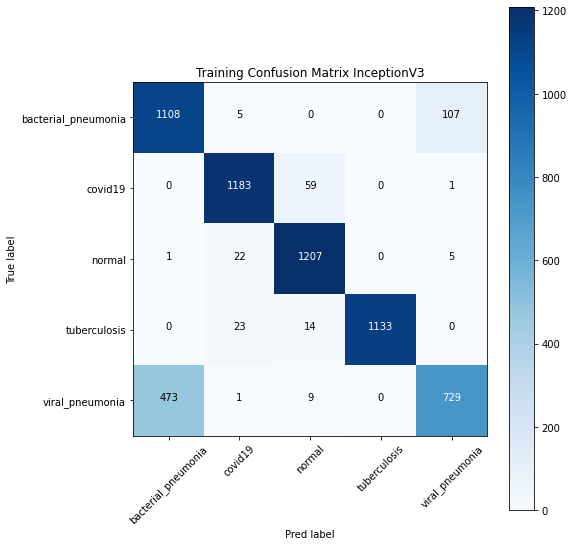

In [46]:
train_all_batches = datagen.flow_from_directory(
    directory=train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)

num_train_steps = len(train_all_batches)

train_predictions = model_inceptionv3.predict(train_all_batches, steps=num_train_steps, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_all_batches.classes

train_class_report = classification_report(
    train_true_labels,
    train_predicted_labels,
    target_names=train_all_batches.class_indices,
    digits=5,
)
print("\nTraining Classification Report InceptionV3 :\n", train_class_report)

train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix InceptionV3")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## Ensamble Model

In [75]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, concatenate
import tensorflow as tf


model1_path = '/kaggle/working/file_training/resnet50.h5'
model2_path = '/kaggle/working/file_training/vgg19.h5'

model1 = load_model(model1_path)
model1 = Model(inputs=model1.inputs, outputs=model1.outputs, name='model_resnet')

model2 = load_model(model2_path)
model2 = Model(inputs=model2.inputs, outputs=model2.outputs, name='model_vgg')

model_input = Input(shape=(image_size, image_size, 3))
model_outputs = [model(model_input) for model in [model1, model2]]

merged_output = concatenate(model_outputs)
output = Dense(5, activation='softmax')(merged_output)

ensemble_model = Model(inputs=model_input, outputs=output, name='ensemble_model')

ensemble_model.summary()

Model: "ensemble_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_resnet (Functional)       (None, 5)            38807217    input_12[0][0]                   
__________________________________________________________________________________________________
model_vgg (Functional)          (None, 5)            24233841    input_12[0][0]                   
__________________________________________________________________________________________________
concatenate_10 (Concatenate)    (None, 10)           0           model_resnet[0][0]               
                                                                 model_vgg[0][0]     

In [76]:
reduce_lr = ReduceLROnPlateau(
    monitor="val_acc",
    factor=0.5,
    patience=2,
    verbose=1,
    mode="max",
    min_lr=1e-6,
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=7,
    restore_best_weights=True,
)

In [77]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
ensemble_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

history_ensemble = ensemble_model.fit(
    train_batches,
    validation_data=test_batches,
    epochs=25,
    verbose=1,
    callbacks = [early_stopping, reduce_lr]
)

Epoch 1/25
190/190 [==============================] - 75s 333ms/step - loss: 1.3758 - acc: 0.3954 - val_loss: 1.2211 - val_acc: 0.5957
Epoch 2/25
190/190 [==============================] - 60s 314ms/step - loss: 1.2073 - acc: 0.5359 - val_loss: 1.0638 - val_acc: 0.6324
Epoch 3/25
190/190 [==============================] - 60s 313ms/step - loss: 1.0912 - acc: 0.5933 - val_loss: 0.9639 - val_acc: 0.6640
Epoch 4/25
190/190 [==============================] - 60s 314ms/step - loss: 1.0248 - acc: 0.6058 - val_loss: 0.9029 - val_acc: 0.6894
Epoch 5/25
190/190 [==============================] - 60s 314ms/step - loss: 0.8484 - acc: 0.6745 - val_loss: 0.7168 - val_acc: 0.7220
Epoch 6/25
190/190 [==============================] - 60s 314ms/step - loss: 0.7772 - acc: 0.6896 - val_loss: 0.7115 - val_acc: 0.7200
Epoch 7/25
190/190 [==============================] - 60s 314ms/step - loss: 0.7188 - acc: 0.7046 - val_loss: 0.6904 - val_acc: 0.6914

Epoch 00007: ReduceLROnPlateau reducing learning rate 

In [78]:
train_score_ensemble = ensemble_model.evaluate(train_batches, verbose=1)
test_score_ensemble = ensemble_model.evaluate(test_batches, verbose=1)

31/31 [==============================] - 8s 264ms/step - loss: 0.5015 - acc: 0.7525


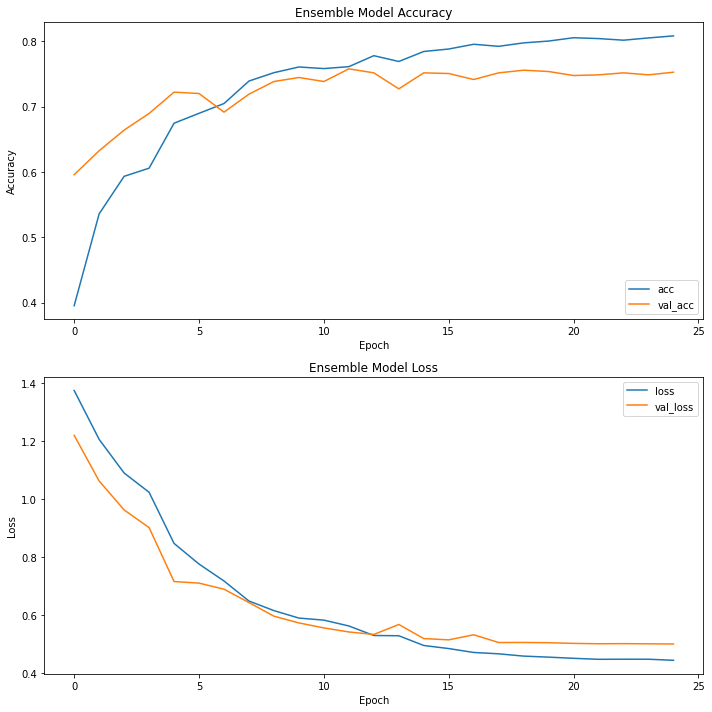

In [79]:
plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)
plt.plot(history_ensemble.history["acc"])
plt.plot(history_ensemble.history["val_acc"])
plt.title("Ensemble Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["acc", "val_acc"], loc="lower right")

plt.subplot(2, 1, 2)
plt.plot(history_ensemble.history["loss"])
plt.plot(history_ensemble.history["val_loss"])
plt.title("Ensemble Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss", "val_loss"], loc="upper right")

plt.tight_layout()
plt.show()


Found 982 images belonging to 5 classes.
31/31 [==============================] - 13s 245ms/step

Classification Report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.50135   0.90291   0.64471       206
            covid19    0.95588   0.92417   0.93976       211
             normal    0.93564   0.90431   0.91971       209
       tuberculosis    0.94366   0.95714   0.95035       140
    viral_pneumonia    0.55556   0.16204   0.25090       216

           accuracy                        0.75255       982
          macro avg    0.77842   0.77011   0.74109       982
       weighted avg    0.76643   0.75255   0.72359       982



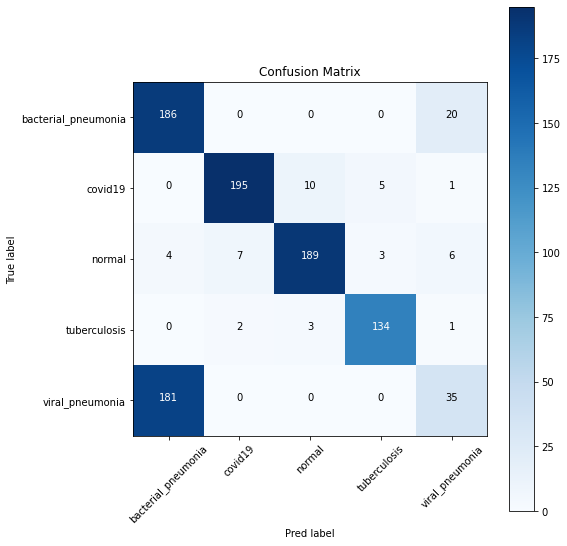

In [80]:
test_all_batches = datagen.flow_from_directory(
    directory=test_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)
true_labels = test_batches.classes

num_test_steps = len(test_all_batches)

predictions = ensemble_model.predict(test_batches, steps=num_test_steps, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)
class_report = classification_report(
    true_labels, predicted_labels, target_names=train_batches.class_indices, digits=5
)
print("\nClassification Report:\n", class_report)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)
thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(
        j,
        i,
        conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

Found 6080 images belonging to 5 classes.
190/190 [==============================] - 49s 257ms/step

Training Classification Report Ensemble Model :
                      precision    recall  f1-score   support

bacterial_pneumonia    0.55344   0.81066   0.65780      1220
            covid19    0.97090   0.96621   0.96855      1243
             normal    0.95878   0.94170   0.95016      1235
       tuberculosis    0.99131   0.97521   0.98320      1170
    viral_pneumonia    0.61416   0.35066   0.44643      1212

           accuracy                        0.80905      6080
          macro avg    0.81772   0.80889   0.80123      6080
       weighted avg    0.81749   0.80905   0.80120      6080



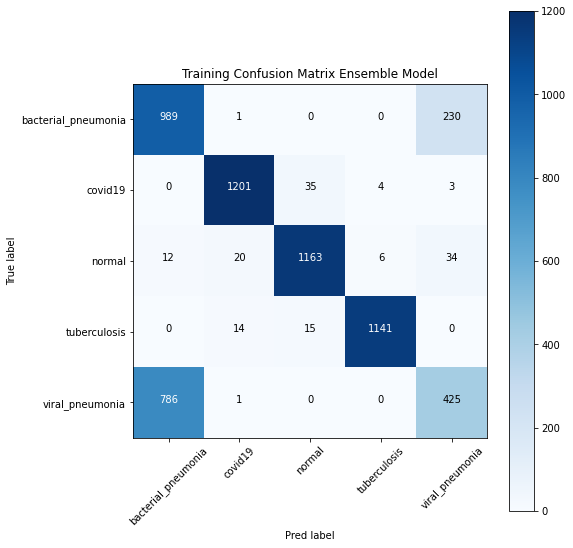

In [81]:
train_all_batches = datagen.flow_from_directory(
    directory=train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)

num_train_steps = len(train_all_batches)

train_predictions = ensemble_model.predict(train_all_batches, steps=num_train_steps, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_all_batches.classes

train_class_report = classification_report(
    train_true_labels,
    train_predicted_labels,
    target_names=train_all_batches.class_indices,
    digits=5,
)
print("\nTraining Classification Report Ensemble Model :\n", train_class_report)

train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix Ensemble Model")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

In [82]:
# model.save("/kaggle/working/file_training/ensemble_model.h5")